# Covid 19
# Implementation of SEIR model + connectivity graph



## Some covid19 data

recovery_time = 7-14 days, so $\gamma$= 7-14 days

https://www.health.harvard.edu/diseases-and-conditions/coronavirus-resource-center



This idea can probably be more readily seen if we say that the typical time between contacts is $T_{c} = \beta^{-1}$, and the typical time until recovery is $T_{r} = \gamma^{-1}$. 

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

## Not reported cases

The reported cases are approximately 14% of the total cases.

https://science.sciencemag.org/content/sci/early/2020/03/13/science.abb3221.full.pdf

Total cases = 100*reported/14

## Data coronavirus

https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported


https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Chile

In [24]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pylab
from scipy.integrate import odeint
from numba import jit

import matplotlib.pyplot as plt

%matplotlib inline
plt.ion()
plt.rcParams['figure.figsize'] = 10, 8

## Classic SEIR model 

Implementation of a classic SEIR model with infected data.

\begin{equation}
    \begin{aligned}
        \frac{dS}{dt}  &= \frac{-\beta IS}{N}\\
        \frac{dE}{dt}  &= \frac{\beta IS}{N} - \sigma E\\
        \frac{dI}{dt}  &= \sigma E -\gamma I\\
        \frac{dR}{dt}  &= \gamma I\\
    \end{aligned}
\end{equation}


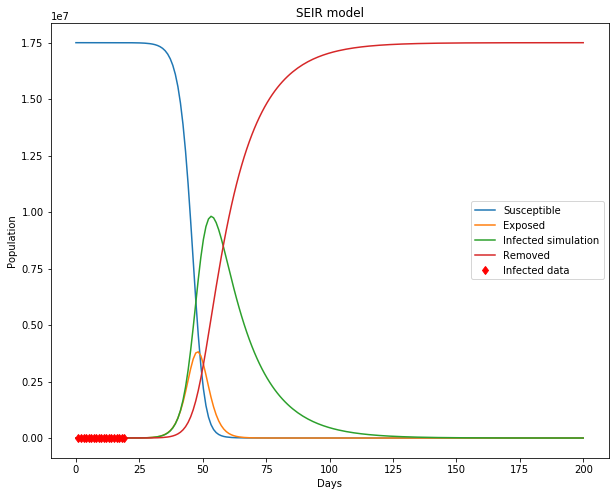

Total infected people  17499399.498217244
Percentage infected people  99.99656856124139
Maximum number of infected  9814949.731305517
Days in wich infected are maximum  53


In [57]:
#model constant
beta = 0.8  
sigma = 0.4
gamma = 1/14
real_cumul_infected = [ 1, 3, 4, 5, 7, 10, 13, 17, 23, 34, 43, 61, 75, 156, 201, 238, 342, 434, 537 ]
real_daily_infected = [1, 2, 1, 1, 2, 3, 3, 4, 6, 11, 9, 18, 14, 81, 45, 37, 104, 92, 103]

days = np.arange(1,len(real_cumul_infected)+1)
days_long = np.arange(1,38)

#SEIR model function
def model_SEIR(y, t):
    S0 = y[0]
    E0 = y[1]
    I0 = y[2]
    R0 = y[3]
    dSdt = -beta * I0 * S0 /N
    dEdt = beta * I0 * S0 /N - sigma * E0 
    dIdt = sigma * E0  - (gamma * I0)
    dRdt = gamma * I0 
    return [dSdt, dEdt, dIdt, dRdt]

#initial conditions
Si = 17500000
Ei = 0
Ii = 1
Ri = 0
N = Si + Ei + Ii + Ri
t  = np.linspace(0, 200., 200) # time grid, (from, to, number_of_step)
y0 = [Si, Ei, Ii, Ri]          # initial conditions vector
    
# solve the ODEs
soln = odeint(model_SEIR, y0, t) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S = soln[:, 0]
E = soln[:, 1]
I = soln[:, 2]
R = soln[:, 3]

# plot results
plt.figure()
plt.plot(t, S, label='Susceptible')
plt.plot(t, E, label='Exposed')
plt.plot(t, I, label='Infected simulation')
plt.plot(t, R, label='Removed')
plt.plot(days, real_cumul_infected, 'rd', label="Infected data")
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('SEIR model')
#plt.xlim(0, 25)  # uncomment this two line to see the manual curve fitting
#plt.ylim(0,600)
plt.legend(loc=0)
plt.show()

print("Total infected people ", R[-1])
print("Percentage infected people ", R[-1] *100/Si)
print("Maximum number of infected ", I.max())
print("Days in wich infected are maximum ", I.argmax())

## SEIR model + Graph implementation

\begin{equation}
    \begin{aligned}
        \frac{dS_i}{dt}  &= -\beta S_i \sum^N_{j=1} g_{ij}I_j \\
        \frac{dE_i}{dt}  &= \beta S_i \sum^N_{j=1} g_{ij}I_j - \sigma  E_i \\
        \frac{dI_i}{dt}  &= \sigma  E_i - \gamma I_i \\
        \frac{dR_i}{dt}  &= \gamma I_i \\
    \end{aligned}
\end{equation}

This model doesn't include $\alpha$ and $\delta_{i,j}$

In [12]:
#Here I create the model
#model constant
beta_i = 10
sigma = 1/11
gamma = 1/7 # 7< gamma < 14, recovery time
N = 1 # just for simplicity, use 1. Should be the real number.

#@jit
def model_SEIR_graph(inicond, t):
    #Create the numpy arrays that will have the output data
    Sout = np.zeros(10) #from here is different to 1 dimension
    Eout = np.zeros(10)
    Iout = np.zeros(10)
    Rout = np.zeros(10)
    
    #reshape to extract the initial condition states
    inicond = inicond.reshape(4,10)
    
    #Extract initial conditions for every state
    S = inicond[0]
    E = inicond[1]
    I = inicond[2]
    R = inicond[3]
    
    #print("Sout ", Sout)
    #print("Eout ", Eout)
    #print("Iout ", Iout)
    #print("Rout ", Rout)
    
    # Here all the coupled ODE are created, 100 ODES
    # in this example. g[x][y] = connectivity matrix
    for x in range(1,9):
        for y in range(1,9):
            Sout[x] += -beta*S[x]/N * I[y] * g[x][y]
            Eout[x] += beta*S[x]/N *I[y] * g[x][y] - sigma * E[x]
            Iout[x] += sigma * E[x] - gamma * I[x]
            Rout[x] += gamma * I[x]
        
    return np.concatenate((Sout, Eout, Iout, Rout)).reshape((40))

### Random connectivity matrix

A random simmetrical connectivity matrix $g_{i,j}$ is created. This to be used in the example.

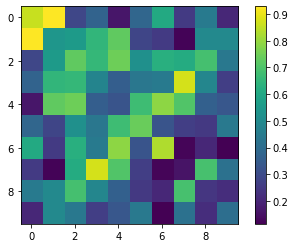

In [5]:
g = np.random.rand(10,10) # 10x10 matrix
g = (g + g.T)/2
plt.imshow(g)
plt.colorbar()
plt.show()

### Now the model is integrated with python odeint solver

In [14]:
#initial conditions
t  = np.linspace(0, 150, 1000) # time grid, (from, to, number_of_step)

#define initial states vector
Si = np.full(10,500) #10 dim array with 500 persons per square
Ei = np.zeros(10)
Ii = np.zeros(10)
Ri = np.zeros(10)

Ii[5] = 50 #50 initial infected persons in node 5

inicond = np.concatenate((Si, Ei, Ii, Ri))
#print(inicond.shape)

#reshape to fit with odeint requirement 
x0 = inicond.reshape(40)
    
# solve the ODEs
soln = odeint(model_SEIR_graph, x0, t) # (model, initial_conditions, time_series)

#for debugging
#print("shape soln, (rows, columns)=(time, state_i)", soln.shape)

### Now reshape the output to plot

In [18]:
#Define variables to plot
Splot = soln[:, :10]   # all rows, 10 columns (all S, until E)
Eplot = soln[:, 10:20]
Iplot = soln[:, 20:30]
Rplot = soln[:, 30:40]

#print(Splot.shape)
#print(Splot[:, 1].shape)

#variable to plot the sum of all states
Splotsum = 0
Eplotsum = 0
Iplotsum = 0
Rplotsum = 0

for i in range(10):
    Splotsum += Splot[:,i]
    Eplotsum += Eplot[:,i]
    Iplotsum += Iplot[:,i]
    Rplotsum += Rplot[:,i]

Splotsum = Splotsum/10 # divide 10, the number of nodes
Eplotsum = Eplotsum/10
Iplotsum = Iplotsum/10
Rplotsum = Rplotsum/10

### Now with the data ready to plot, plot

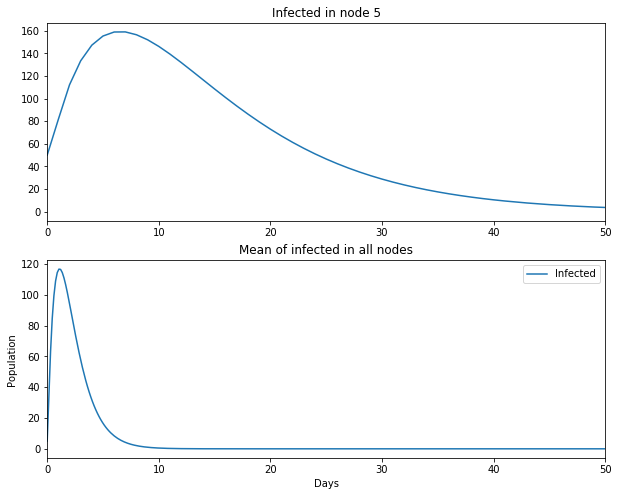

Maximum number of infected 116.59216192138315


In [55]:
#Node to plot
node = 5

#plot results
plt.subplot(2, 1, 1)
plt.title('Infected in node {}'.format(node))
plt.xlim(0, 50)
plt.plot(Iplot[:, node]) #axis y=t, axis x=space, the number show the node

plt.subplot(2, 1, 2)
#plt.plot(t, Splotsum, label='Susceptible')
#plt.plot(t, Eplotsum, label='Exposed')
plt.plot(t, Iplotsum, label='Infected')
#plt.plot(t, Rplotsum, label='Removed')
plt.legend(loc=0)
plt.xlabel('Days')
plt.ylabel('Population')
plt.xlim(0,50)
plt.title('Mean of infected in all nodes')

plt.show()
print("Maximum number of infected", np.max(Iplotsum))

### And plotting all the infected in all the nodes, i.e. 10 curves

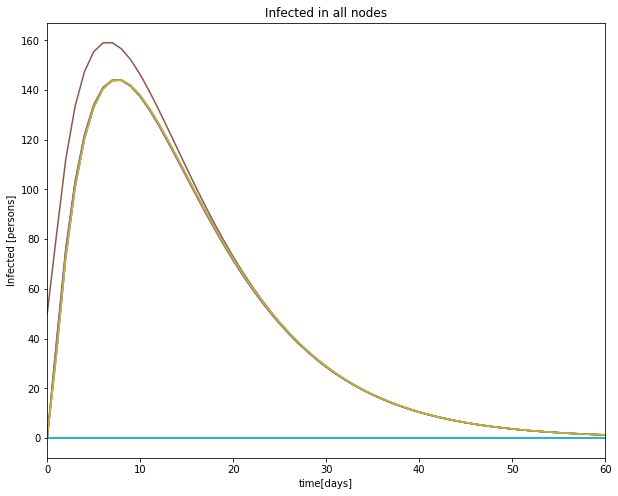

In [34]:
plt.plot(Iplot)
plt.xlim(0, 60)
plt.title("Infected in all nodes")
plt.xlabel("time[days]")
plt.ylabel("Infected [persons]")

plt.show()

## Ignorar hacia abajo ##

Implementación de integrador Runge-Kutta de 4to orden. Se le dan los mismos argumentos que a odeint.

In [73]:
#RK4 para n nodos
def rk4(f, init_cond, t): # (funcion, vector_init_cond, time_series)
    t0 = init_cond[0]
    
    #step size
    h  = t[-1]/len(t)
    
    yout = np.empty(0)
    y = init_cond
    for i in range(len(t)): 
        k1 = h * f(y, t0)
        k2 = h * f(y + 0.5 * k1, t0 + 0.5 * h)
        k3 = h * f(y + 0.5 * k2, t0 + 0.5 * h)
        k4 = h * f(y + k3, t0 + h)

        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 

        t0 = t0 + h
        #print("yout ", yout)
        yout = np.append(yout, y)
    
    yout = yout.reshape(len(t), len(init_cond))
    #yout = yout.reshape(len(t), 4)
    
    
    return yout

In [74]:
#esta función la integra bien
def f(y, t):
    out = np.array([y[0]/2, y[3], 2*y[2], 55])
    return (out)
    #return ((t - y[0])/2+y[1]+y[2]+y[3])

In [75]:
#ODEINT
t  = np.linspace(0, 2, 300)
init_cond = [0, 1, 2, 3]
out2 = odeint(f, init_cond, t)
print('The value of y at x is:', out2)
print(len(out2))

The value of y at x is: [[  0.           1.           2.           3.        ]
 [  0.           1.0212973    2.02693567   3.36789298]
 [  0.           1.04505542   2.05423399   3.73578595]
 ...
 [  0.         115.49321596 106.31340546 112.26421405]
 [  0.         116.24537757 107.74521438 112.63210702]
 [  0.         117.         109.19630662 113.        ]]
300


In [76]:
#RK4
t  = np.linspace(0, 2, 300)
init_cond = [0, 1, 2, 3]
out = rk4(f, init_cond, t)
print('The value of y at x is:', out)
print(len(out))

The value of y at x is: [[  0.           1.02122222   2.02684524   3.36666667]
 [  0.           1.04488889   2.05405081   3.73333333]
 [  0.           1.071        2.08162155   4.1       ]
 ...
 [  0.         115.49822222 106.32288115 112.26666667]
 [  0.         116.24788889 107.75001263 112.63333333]
 [  0.         117.         109.19629995 113.        ]]
300


In [77]:
#ODEINT
#initial conditions
t  = np.linspace(0, 150, 1000) # time grid

Si = np.full(10,500) #10 dim array with 500 agents per square
Ei = np.zeros(10)
Ii = np.zeros(10)
Ri = np.zeros(10)

Ii[5] = 50

inicond = np.concatenate((Si, Ei, Ii, Ri))
print(inicond.shape)
x0 = inicond.reshape(40)
    
# solve the ODEs
soln = odeint(model_SEIR_graph, x0, t)

print("shape soln, (filas, columnas)=(tiempo, estado_i)", soln.shape)

(40,)
shape soln, (filas, columnas)=(tiempo, estado_i) (1000, 40)


In [78]:
#RK4
#initial conditions
t  = np.linspace(0, 150, 1000) # time grid

Si = np.full(10,500) #10 dim array with 500 agents per square
Ei = np.zeros(10)
Ii = np.zeros(10)
Ri = np.zeros(10)

Ii[5] = 50

inicond = np.concatenate((Si, Ei, Ii, Ri))
#x0 = inicond.reshape(40)
x0 = inicond
    
# solve the ODEs
soln = rk4(model_SEIR_graph, x0, t)

In [79]:
print(soln)

[[5.00000000e+02 4.99999953e+02 4.99999914e+02 ... 2.61484220e-07
  2.45409111e-07 0.00000000e+00]
 [5.00000000e+02 4.99999911e+02 4.99999835e+02 ... 1.82243962e-06
  1.71040236e-06 0.00000000e+00]
 [5.00000000e+02 4.99999871e+02 4.99999763e+02 ... 5.32243000e-06
  4.99522469e-06 0.00000000e+00]
 ...
 [5.00000000e+02 4.99999433e+02 4.99998952e+02 ... 5.31567700e-04
  4.98879892e-04 0.00000000e+00]
 [5.00000000e+02 4.99999433e+02 4.99998952e+02 ... 5.31567700e-04
  4.98879892e-04 0.00000000e+00]
 [5.00000000e+02 4.99999433e+02 4.99998952e+02 ... 5.31567700e-04
  4.98879892e-04 0.00000000e+00]]


In [80]:
soln.shape

(1000, 40)

In [81]:
#Define variables to plot
Splot = soln[:, :10]   # all rows, 10 columns (all S, until E)
Eplot = soln[:, 10:20]
Iplot = soln[:, 20:30]
Rplot = soln[:, 30:40]

Text(0.5, 1.0, 'Infected in node 9')

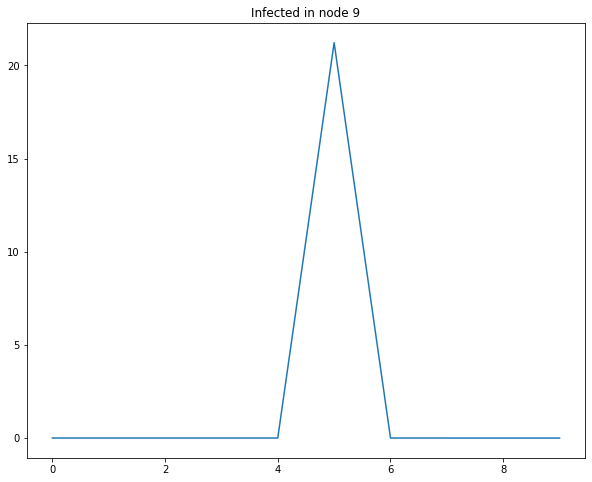

In [84]:
plt.plot(Iplot[9])
plt.title("Infected in node 9")